In [1]:
%cd ..
import gym
import gym_game
import matplotlib.pyplot as plt
env = gym.make('Parkme')
reset, _ = env.reset()
n_actions = env.action_space.n
states_dim = env.observation_space.shape[0]
print(n_actions, states_dim)

/home/yvovaa/fork/HSE_ML_P2024
9 7


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


In [2]:
from sklearn.neural_network import MLPClassifier
import pickle
def load_agent(path=None):
    if path is None:
        agent = MLPClassifier(
            hidden_layer_sizes=(128, 64, 32),
            activation='tanh',
        )
        return agent.partial_fit([reset] * n_actions, range(n_actions), range(n_actions))
    with open(path, 'rb') as model:
        return pickle.load(model)
agent = load_agent('models_bin/CEM6.pkl')

In [3]:
import numpy as np
import random
def generate_session(env, agent, exploration_rate=0.8):
    states, actions = [], []
    total_reward = 0
    try:
        s, _ = env.reset()
    except IndexError:
        env.close()
        del env
        env = gym.make('Parkme')
        s, _ = env.reset()
    for _ in range(3000):
        if random.random() > exploration_rate:
            action = np.random.choice(list(range(n_actions)))
        else:
            probs = agent.predict_proba([s])[0]
            action = np.random.choice(list(range(n_actions)), p = probs)    
        new_s, r, terminated, _, _ = env.step(action)
        states.append(s)
        actions.append(action)
        total_reward += r

        s = new_s
        if terminated:
            break
    return states, actions, total_reward


In [4]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile):
    reward_threshold = np.percentile(rewards_batch, percentile)
    elite_states = []
    elite_actions = []
    for i in range(len(states_batch)):
        if rewards_batch[i] >= reward_threshold:
            elite_states.extend(states_batch[i])
            elite_actions.extend(actions_batch[i])

    return elite_states, elite_actions

In [5]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])
    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label="Mean rewards")
    plt.plot(list(zip(*log))[1], label="Reward thresholds")
    plt.legend()
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines(
        [np.percentile(rewards_batch, percentile)],
        [0],
        [100],
        label="percentile",
        color="red",
    )
    plt.legend()
    plt.grid()
    plt.show()


In [6]:
extra_elit_states = []
extra_elit_actions = []
for i in range(1, 21):
    with open(f'samples/obs{i}.txt', 'r') as file:
        extra_elit_states.extend([[float(s) for s in sample[1:-2].split(', ')]for sample in file.readlines()])

    with open(f'samples/act{i}.txt', 'r') as file:
        extra_elit_actions.extend([int(s) for s in file.readlines()])
        
for _ in range(100):
    extra_elit_states = np.array(extra_elit_states)
    extra_elit_actions = np.array(extra_elit_actions)
    agent = agent.partial_fit(extra_elit_states, extra_elit_actions)

In [7]:
percentile = 85
log = []
n_epochs = 80
best_reward = -270539.1549951534
worst_reward = 1e12

mean reward = -587246.628, threshold=-97312.273


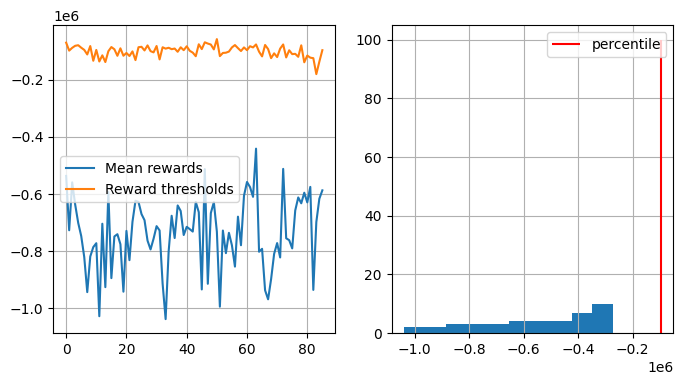

 54%|█████▍    | 86/160 [46:44<43:33, 35.31s/it]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
 54%|█████▍    | 86/160 [46:57<40:24, 32

KeyboardInterrupt: 

In [8]:
%%time
from tqdm import tqdm
from joblib import parallel_backend

for i in tqdm(range(n_epochs)):
    sessions = [generate_session(env, agent) for _ in range(100)]
    states_batch, actions_batch, rewards_batch = zip(*sessions)
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    random_indices = np.random.choice(len(extra_elit_actions), 5000, replace=False)
    elite_states.extend(extra_elit_states[random_indices])
    elite_actions.extend(extra_elit_actions[random_indices])
    with parallel_backend('loky', n_jobs=-1):
        agent = agent.partial_fit(elite_states, elite_actions)
    mean = np.mean(rewards_batch)
    if mean > best_reward:
        with open('models_bin/CEM6.pkl', 'wb') as model:
            pickle.dump(agent, model)
        best_reward = mean
    worst_reward = min(worst_reward, mean)
    show_progress(
        rewards_batch, log, percentile, reward_range=[worst_reward, best_reward]
    )

In [9]:
print(best_reward)

-270539.1549951534


In [ ]:
# import pickle
# with open('models_bin/CE.pkl', 'wb') as file:
#     pickle.dump(agent, file)

Стоило бы конечно записывать
1) Первый вариант - уже даже не помню, что там было, но ничего хорошего
2) Второй вариант - та же нейронка, что и в 4, награда - расстояние * разность углов + мелочь
3) Третий вариант - какая-то слабая модификация второго
4) Четвертый вариант - один скрытый слой 128 нейронов, тангенс, 8 сэмплов, награда такая: 
`-` dst - (int(abs(car_angle - pp_angle)) % 180) / (dst + 0.01)+ self.core.scene.car_m.health / 100 - self.time + self.core.scene.car_m.is_car_parked * 1000
Подозреваю, что нужна сеть побольше. Во время создания искуственных сессий понял, что надо делать не больше нескольких тысяч степов (об этом можно было додуматься и логически, вспомнив, что fps у нас 60 кадров, но я почему-то этого не сделал)
5) Пятый вариант - два скрытых слоя (128, 64), сигмоида, 20 семплов, награда та же, только деленная на 100. 355825.87054126075 - лучшая

Но все таки скорее всего дело в неправильной награде, потому что уж stable baselines должны были бы обучиться (наверное), хотя мб там какие нибудь взрывающиеся градиенты из-за того, что порядок награды несколько милиардов (но вообще лосс не по награде считается, так что вряд ли). На 5 эпохе вышла на плато - выучила стоять на месте. Очень грустно, прям плакать хочется)))

6) Почему-то мне хочется тангенс, добавил скрытый слой 32 нейрона. За 280 эпох модель ничему не научилась

Самый перспективный вариант - второй, там машинка научилась поворачивать на нужный угол, но почему-то не приближаться к парковке

Думаю, что придется отказаться от этой идеи... Каждое маленькое действие слишком незначимо относительно общей награды, модель просто не может, совершая на начальных этапах обучения рандомные действия, пробиться к нормальной награде. Надо использовать Q-learning, который считает полезность каждого действия.

Единственное, что ВОЗМОЖНО будет работать - это сначала обучать модель на вручную созданных сессиях, но этих сессий может понадобиться очень-очень много...

Последняя идея - взять модель поумнее, например GRU. Чего-то не получается :(